In [5]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, davies_bouldin_score
import shap

# Step 1: Load Data
file_path = r"c:\Users\Ankit\Documents\Milestone II project\Milestone_2\Data\cleaned_census_data.csv"
df = pd.read_csv(file_path)

# Step 2: Data Preprocessing
# Handle missing values if any
df.dropna(inplace=True)

In [9]:
# Step 3: Aggregation Function
def aggregate_metrics(df):
    aggregation_methods = {
        "mil pop": "median",
        "unemployment %": "mean",
        "mean income": "mean",
        "median income": "median",
        "vacant housing units": "sum",
        "rental vacany rate": "mean",
        "% below poverty line": "mean",
        "median house value": "median"
    }
    return df.groupby("NAME").agg(aggregation_methods).reset_index()

# Aggregate over all years
df_all_years = aggregate_metrics(df)

# Aggregate over the last 5 years (2018-2022)
df_last_5_years = aggregate_metrics(df[df["Year"].between(2018, 2022)])


In [23]:
# Function for clustering
def perform_clustering(df):
    df = df.copy()  # Prevent modifying the original dataframe
    
    # Apply log transformation for highly skewed features
    df['mil pop_log'] = np.log1p(df['mil pop'])
    df['median house value_log'] = np.log1p(df['median house value'])
    df['% below poverty line_log'] = np.log1p(df['% below poverty line'])
    
    # Define updated features after log transformation
    features_to_scale = ["mil pop_log", "median income", "median house value_log", "% below poverty line_log", "unemployment %"]
    
    # Standardization
    scaler = StandardScaler()
    df_scaled = pd.DataFrame(scaler.fit_transform(df[features_to_scale]), columns=features_to_scale)
    df_scaled.insert(0, "NAME", df["NAME"])  # Retain categorical column
    
    # Determine Optimal Clusters (Elbow Method)
    wcss = []
    K_range = range(1, 25)
    for k in K_range:
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        kmeans.fit(df_scaled[features_to_scale])
        wcss.append(kmeans.inertia_)
    
    plt.figure(figsize=(8, 5))
    plt.plot(K_range, wcss, marker="o", linestyle="-")
    plt.xlabel("Number of Clusters (K)")
    plt.ylabel("Within-Cluster Sum of Squares (WCSS)")
    plt.title("Elbow Method for Optimal K")
    plt.grid(True)
    plt.show()
    
    # Apply K-Means Clustering with Optimal K=5
    optimal_k = 5
    kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
    df_scaled["Cluster"] = kmeans.fit_predict(df_scaled[features_to_scale])
    
    # Evaluate Cluster Performance
    sil_score = silhouette_score(df_scaled[features_to_scale], df_scaled["Cluster"])
    db_score = davies_bouldin_score(df_scaled[features_to_scale], df_scaled["Cluster"])
    print(f"Silhouette Score: {sil_score:.4f}")
    print(f"Davies-Bouldin Index: {db_score:.4f}")
    
    # Interpret clusters using SHAP
    explainer = shap.Explainer(kmeans.predict, df_scaled[features_to_scale])
    shap_values = explainer(df_scaled[features_to_scale])
    shap.summary_plot(shap_values, df_scaled[features_to_scale])
    
    # Compute feature importance per cluster
    shap_df = pd.DataFrame(shap_values.values, columns=features_to_scale)
    shap_df["Cluster"] = df_scaled["Cluster"]
    cluster_feature_importance = shap_df.groupby("Cluster").mean().abs()
    print(cluster_feature_importance)
    
    # PCA Visualization
    pca = PCA(n_components=2)
    pca_components = pca.fit_transform(df_scaled[features_to_scale])
    df_scaled["PCA1"], df_scaled["PCA2"] = pca_components[:, 0], pca_components[:, 1]
    
    plt.figure(figsize=(8,6))
    sns.scatterplot(x=df_scaled["PCA1"], y=df_scaled["PCA2"], hue=df_scaled["Cluster"], palette="viridis", alpha=0.7)
    plt.title("Cluster Visualization using PCA")
    plt.xlabel("PCA Component 1")
    plt.ylabel("PCA Component 2")
    plt.legend(title="Cluster")
    plt.grid(True)
    plt.show()
    
    return df_scaled

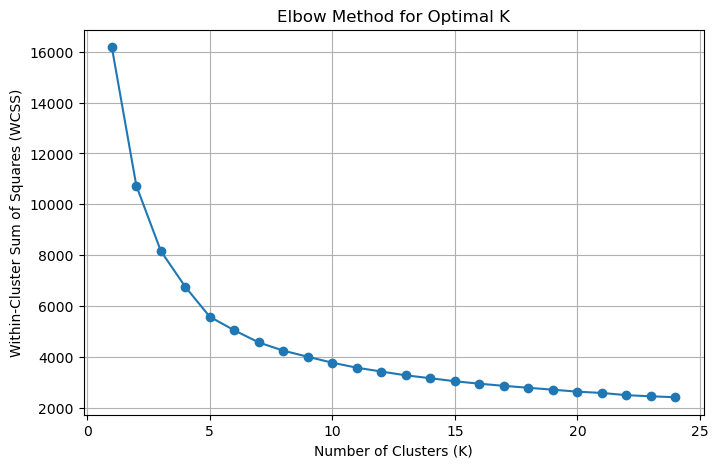

Silhouette Score: 0.2789
Davies-Bouldin Index: 1.0527


ExactExplainer explainer: 3236it [00:46, 53.45it/s]                          


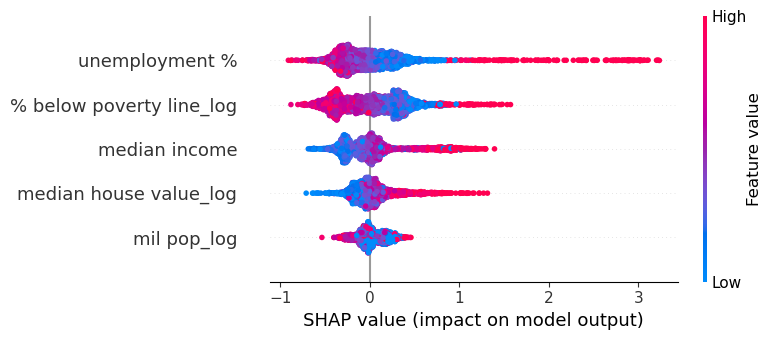

         mil pop_log  median income  median house value_log  \
Cluster                                                       
0           0.044556       0.293735                0.154666   
1           0.056312       0.046793                0.067902   
2           0.162695       0.062569                0.016712   
3           0.001335       0.790924                0.481605   
4           0.008597       0.182825                0.033086   

         % below poverty line_log  unemployment %  
Cluster                                            
0                        0.405367        0.321677  
1                        0.038722        0.146075  
2                        0.274488        0.263535  
3                        0.444399        0.061737  
4                        0.599822        2.021842  


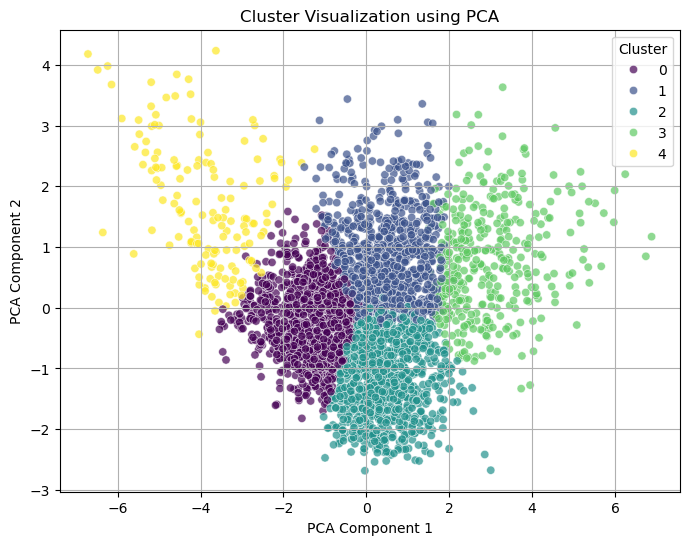

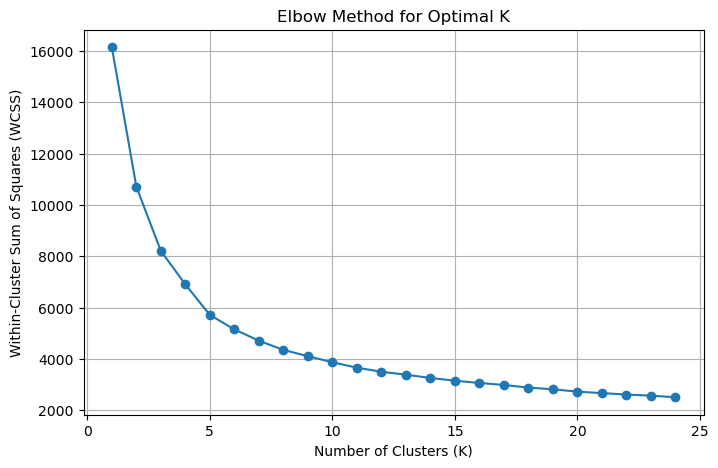

Silhouette Score: 0.2669
Davies-Bouldin Index: 1.0906


ExactExplainer explainer: 3230it [00:35, 66.52it/s]                           


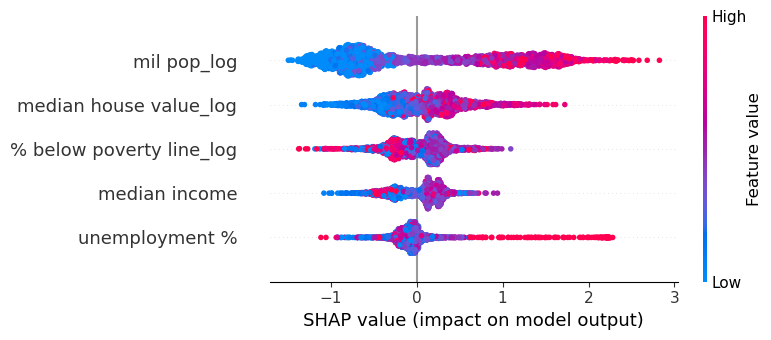

         mil pop_log  median income  median house value_log  \
Cluster                                                       
0           0.521970       0.242369                0.400686   
1           0.781465       0.141048                0.017640   
2           0.783774       0.269918                0.150029   
3           0.176015       0.037726                0.199223   
4           1.339447       0.265303                0.485080   

         % below poverty line_log  unemployment %  
Cluster                                            
0                        0.259087        0.195887  
1                        0.110604        0.107827  
2                        0.211108        0.072777  
3                        0.116817        1.676146  
4                        0.249605        0.040565  


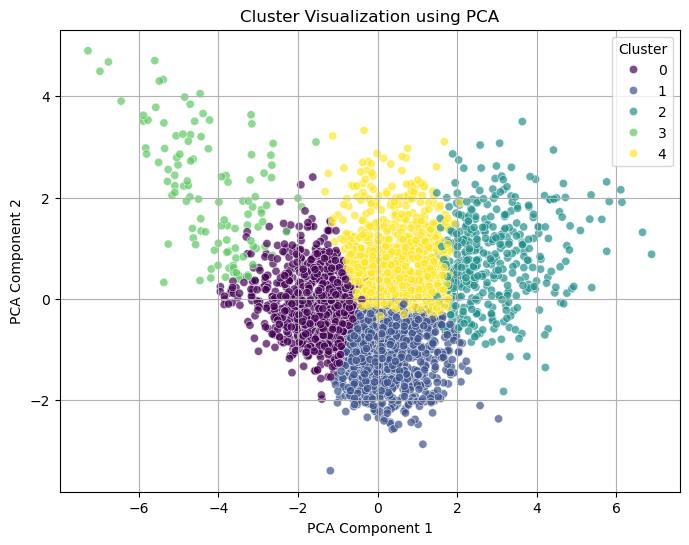

In [24]:

# Step 4: Clustering for both cases
df_clusters_all = perform_clustering(df_all_years)
df_clusters_last_5 = perform_clustering(df_last_5_years)

In [25]:
# Step 5: Compare Clusters
comparison = pd.merge(df_clusters_all[["NAME", "Cluster"]], df_clusters_last_5[["NAME", "Cluster"]], on="NAME", suffixes=("_all", "_last_5"))
comparison["Cluster Match"] = comparison["Cluster_all"] == comparison["Cluster_last_5"]
match_rate = comparison["Cluster Match"].mean()
print(f"Percentage of counties with matching clusters: {match_rate * 100:.2f}%")

Percentage of counties with matching clusters: 26.23%


In [26]:
# Display differences
print(comparison[comparison["Cluster Match"] == False])

                                   NAME  Cluster_all  Cluster_last_5  \
2             Accomack County, Virginia            1               4   
3                     Ada County, Idaho            3               2   
4                    Adair County, Iowa            2               1   
6                Adair County, Missouri            0               4   
8                Adams County, Colorado            1               2   
...                                 ...          ...             ...   
3222            Yuba County, California            1               4   
3223  Yukon-Koyukuk Census Area, Alaska            4               3   
3224               Yuma County, Arizona            1               4   
3225              Yuma County, Colorado            2               1   
3228       Ziebach County, South Dakota            4               3   

      Cluster Match  
2             False  
3             False  
4             False  
6             False  
8             False  
...

In [29]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA

# Convert SHAP values to a DataFrame for last 5 years clusters
shap_df_last_5 = pd.DataFrame(shap_values.values, columns=features_to_scale)

# Add the cluster labels to the SHAP values
shap_df_last_5["Cluster"] = df_clusters_last_5["Cluster"]

# Compute the mean absolute SHAP value for each feature per cluster
cluster_feature_importance_last_5 = shap_df_last_5.groupby("Cluster").mean().abs()

# Fit PCA on the scaled features for last 5 years clusters
pca_last_5 = PCA(n_components=2)
pca_last_5.fit(df_clusters_last_5[features_to_scale])

# Create a DataFrame of PCA loadings
pca_loadings_last_5 = pd.DataFrame(
    pca_last_5.components_,
    columns=features_to_scale,
    index=["PCA1", "PCA2"]
)

# Compute the summary statistics per cluster
df_summary_last_5 = df_clusters_last_5.groupby("Cluster")[features_to_scale].mean()




In [32]:
cluster_feature_importance_last_5

,mil pop_log,median income,median house value_log,% below poverty line_log,unemployment %
Cluster,,,,,
0,0.521970,0.242369,0.400686,0.259087,0.195887
1,0.781465,0.141048,0.017640,0.110604,0.107827
2,0.783774,0.269918,0.150029,0.211108,0.072777
3,0.176015,0.037726,0.199223,0.116817,1.676146
4,1.339447,0.265303,0.485080,0.249605,0.040565


In [31]:
pca_loadings_last_5

,mil pop_log,median income,median house value_log,% below poverty line_log,unemployment %
PCA1,0.289572,0.543269,0.475022,-0.509626,-0.368297
PCA2,0.670381,0.037849,0.337112,0.317309,0.578642


In [30]:
df_summary_last_5

,mil pop_log,median income,median house value_log,% below poverty line_log,unemployment %
Cluster,,,,,
0,-0.545294,-0.807277,-0.797894,0.874942,0.423548
1,-0.707142,0.101863,-0.177649,-0.559852,-0.642784
2,1.082427,1.839038,1.724112,-1.178120,-0.374953
3,-0.484618,-1.805102,-1.004753,2.406986,3.619383
4,0.876571,0.082077,0.326270,-0.021832,-0.005794


In [38]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import spearmanr

# 1. Correlation Analysis: Military Population vs. Economic Indicators
correlation_results = df_clusters_last_5[features_to_scale].corr(method='spearman')

# 2. Compute Mean Economic Indicators for High vs. Low Military Population Clusters
high_mil_pop_threshold = df_clusters_last_5["mil pop_log"].median()  # Define threshold as median
df_clusters_last_5["High Military Presence"] = df_clusters_last_5["mil pop_log"] > high_mil_pop_threshold

economic_summary_by_military = df_clusters_last_5.groupby("High Military Presence")[features_to_scale].mean()

# 3. Cluster-wise Military Population Analysis
cluster_mil_pop_summary = df_clusters_last_5.groupby("Cluster")["mil pop_log"].mean()



# 5. Compute Spearman Correlations for Military Population
correlations = {}
for feature in features_to_scale:
    correlations[feature] = spearmanr(df_clusters_last_5["mil pop_log"], df_clusters_last_5[feature]).correlation

correlation_df = pd.DataFrame.from_dict(correlations, orient='index', columns=["Spearman Correlation with mil pop_log"])

correlation_df



,Spearman Correlation with mil pop_log
mil pop_log,1.000000
median income,0.395437
median house value_log,0.517976
% below poverty line_log,-0.174277
unemployment %,0.060602


In [39]:
economic_summary_by_military


,mil pop_log,median income,median house value_log,% below poverty line_log,unemployment %
High Military Presence,,,,,
False,-0.816785,-0.314272,-0.409416,0.131144,-0.002441
True,0.862017,0.331676,0.432089,-0.138407,0.002576


In [40]:
cluster_mil_pop_summary

Cluster
0   -0.545294
1   -0.707142
2    1.082427
3   -0.484618
4    0.876571
Name: mil pop_log, dtype: float64

C:\Users\Ankit\AppData\Local\Temp\ipykernel_2392\572206739.py:69: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  top_mil_pop_counties = df_clusters_last_5.groupby("Cluster").apply(


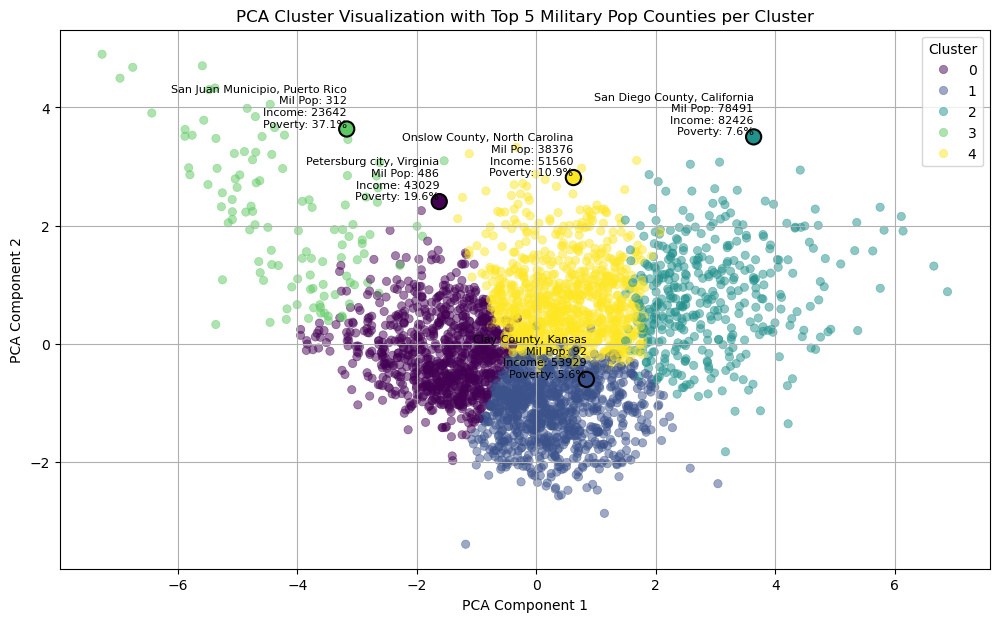

In [46]:
# Re-running the clustering process and extracting relevant data

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# Load the dataset (assuming df contains original data with necessary columns)
# If df is not available, please provide the dataset again.
# Performing aggregation as done earlier

def aggregate_metrics(df):
    aggregation_methods = {
        "mil pop": "median",
        "unemployment %": "mean",
        "mean income": "mean",
        "median income": "median",
        "vacant housing units": "sum",
        "rental vacany rate": "mean",
        "% below poverty line": "mean",
        "median house value": "median"
    }
    return df.groupby("NAME").agg(aggregation_methods).reset_index()

# Aggregate over last 5 years (2018-2022)
df_last_5_years = aggregate_metrics(df[df["Year"].between(2018, 2022)])

# Clustering process
def perform_clustering(df):
    df = df.copy()  # Prevent modifying the original dataframe
    
    # Apply log transformation for highly skewed features
    df['mil pop_log'] = np.log1p(df['mil pop'])
    df['median house value_log'] = np.log1p(df['median house value'])
    df['% below poverty line_log'] = np.log1p(df['% below poverty line'])
    
    # Define updated features after log transformation
    features_to_scale = ["mil pop_log", "median income", "median house value_log", "% below poverty line_log", "unemployment %"]
    
    # Standardization
    scaler = StandardScaler()
    df_scaled = pd.DataFrame(scaler.fit_transform(df[features_to_scale]), columns=features_to_scale)
    df_scaled.insert(0, "NAME", df["NAME"])  # Retain categorical column
    
    # Apply K-Means Clustering with Optimal K=5
    optimal_k = 5
    kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
    df_scaled["Cluster"] = kmeans.fit_predict(df_scaled[features_to_scale])
    
    # PCA for visualization
    pca = PCA(n_components=2)
    pca_components = pca.fit_transform(df_scaled[features_to_scale])
    df_scaled["PCA1"], df_scaled["PCA2"] = pca_components[:, 0], pca_components[:, 1]

    # Merge back actual values for annotations
    df_scaled["mil pop"] = df["mil pop"]
    df_scaled["median income"] = df["median income"]
    df_scaled["% below poverty line"] = df["% below poverty line"]
    
    return df_scaled

# Perform clustering on last 5 years' data
df_clusters_last_5 = perform_clustering(df_last_5_years)

# Get top 5 counties with the highest military population in each cluster
top_mil_pop_counties = df_clusters_last_5.groupby("Cluster").apply(
    lambda x: x.nlargest(1, "mil pop")
).reset_index(drop=True)

# Plot PCA Scatter with Cluster Color Coding
plt.figure(figsize=(12, 7))
scatter = sns.scatterplot(
    data=df_clusters_last_5, 
    x="PCA1", y="PCA2", 
    hue="Cluster", palette="viridis", alpha=0.5, edgecolor=None
)

# Overlay Top 5 Military Population Counties with Same Color as Cluster but with Outline
sns.scatterplot(
    data=top_mil_pop_counties, 
    x="PCA1", y="PCA2", 
    hue="Cluster", palette="viridis", 
    edgecolor="black", linewidth=1.5, s=120, legend=False  # Highlight with black border
)

# Annotate Top Military Counties with Mil Pop, Median Income, and % Below Poverty
for _, row in top_mil_pop_counties.iterrows():
    plt.text(
        row["PCA1"], row["PCA2"], 
        f"{row['NAME']}\nMil Pop: {row['mil pop']:.0f}\nIncome: {row['median income']:.0f}\nPoverty: {row['% below poverty line']:.1f}%", 
        fontsize=8, ha='right', va='bottom', color="black"
    )

plt.title("PCA Cluster Visualization with Top 5 Military Pop Counties per Cluster")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend(title="Cluster", bbox_to_anchor=(1, 1))
plt.grid(True)
plt.show()


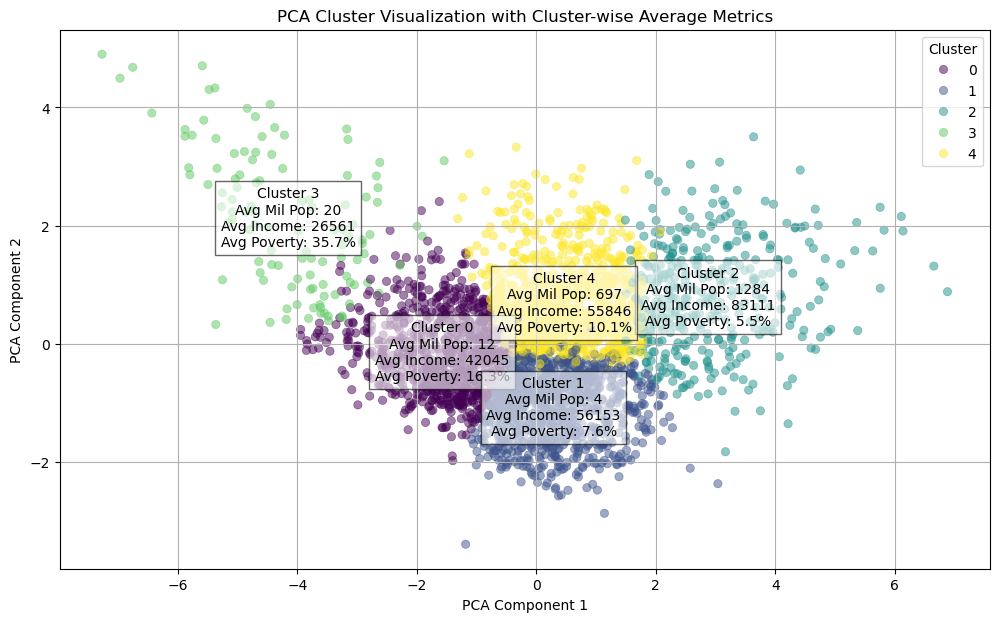

In [50]:
# Ensure df_clusters_last_5 is available
if 'df_clusters_last_5' in locals():
    # Compute average values for each cluster
    cluster_averages = df_clusters_last_5.groupby("Cluster")[
        ["mil pop", "median income", "% below poverty line", "PCA1", "PCA2"]
    ].mean().reset_index()

    # Plot PCA Scatter with Cluster Color Coding
    plt.figure(figsize=(12, 7))
    scatter = sns.scatterplot(
        data=df_clusters_last_5, 
        x="PCA1", y="PCA2", 
        hue="Cluster", palette="viridis", alpha=0.5, edgecolor=None
    )

    # Annotate Cluster Centers with Average Metrics
    for _, row in cluster_averages.iterrows():
        plt.text(
            row["PCA1"], row["PCA2"], 
            f"Cluster {int(row['Cluster'])}\n"
            f"Avg Mil Pop: {row['mil pop']:.0f}\n"
            f"Avg Income: {row['median income']:.0f}\n"
            f"Avg Poverty: {row['% below poverty line']:.1f}%", 
            fontsize=10, ha='center', va='center', 
            bbox=dict(facecolor='white', alpha=0.6, edgecolor='black')
        )

    plt.title("PCA Cluster Visualization with Cluster-wise Average Metrics")
    plt.xlabel("PCA Component 1")
    plt.ylabel("PCA Component 2")
    plt.legend(title="Cluster", bbox_to_anchor=(1, 1))
    plt.grid(True)
    plt.show()
else:
    print("Dataset not found. Please upload the dataset to proceed.")


In [52]:
import pandas as pd

# Select 10 random counties from each cluster
random_counties_per_cluster = df_clusters_last_5.groupby("Cluster").apply(
    lambda x: x.sample(n=10, random_state=42) if len(x) >= 10 else x
).reset_index(drop=True)

# Select relevant columns
random_counties_df = random_counties_per_cluster[["Cluster", "NAME", "mil pop", "median income", "% below poverty line"]]

random_counties_df

C:\Users\Ankit\AppData\Local\Temp\ipykernel_2392\1891449694.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  random_counties_per_cluster = df_clusters_last_5.groupby("Cluster").apply(


,Cluster,NAME,mil pop,median income,% below poverty line
0,0,"Crosby County, Texas",0.0,42470.0,17.34
1,0,"Seminole County, Oklahoma",2.0,39373.0,17.72
2,0,"Poinsett County, Arkansas",7.0,40921.0,16.18
3,0,"Gray County, Texas",0.0,50635.0,13.54
4,0,"Aransas County, Texas",0.0,47924.0,13.06
5,0,"Gogebic County, Michigan",14.0,38839.0,10.34
6,0,"Obion County, Tennessee",43.0,39985.0,14.34
7,0,"Gladwin County, Michigan",4.0,45957.0,10.94
8,0,"Lowndes County, Alabama",0.0,31961.0,20.66
9,0,"Pike County, Alabama",25.0,39218.0,11.70
